In [1]:
import numpy as np
import pandas as pd 
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
!pip install seqeval
!pip install transformers
from seqeval.metrics import f1_score, accuracy_score, precision_score, recall_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16179 sha256=153b8592aa6be08339304dde11aca33d612ce297a5949d8f267755b8cef04a17
  Stored in directory: /root/.cache/pip/wheels/b2/a1/b7/0d3b008d0c77cd57332d724b92cf7650b4185b493dc785f00a
Successfully built seqeval


In [3]:
from transformers import BertModel
bert = BertModel.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
from transformers import BertTokenizerFast,BertForTokenClassification
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
tokenizer.add_tokens(['B_geo','I_geo','B_per','I_per','B_org','I_org','B_gpe','I_gpe','B_tim','I_tim','B_art','I_art','B_eve','I_eve','B_nat','I_nat'])
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [5]:
data = pd.read_csv('../input/ner-data/ner.csv')

In [6]:
data.head()

,text,labels
0,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
1,Iranian officials say they expect to get acces...,B-gpe O O O O O O O O O O O O O O B-tim O O O ...
2,Helicopter gunships Saturday pounded militant ...,O O B-tim O O O O O B-geo O O O O O B-org O O ...
3,They left after a tense hour-long standoff wit...,O O O O O O O O O O O
4,U.N. relief coordinator Jan Egeland said Sunda...,B-geo O O B-per I-per O B-tim O B-geo O B-gpe ...


**Warning** 


In this Notebook, we will perform NER for Person,Location and Organization. So I will replace other tags with 'O' in the following funtions. If you intend to work for all the entities in the dataset, just remove the following "preprocess_dataset" function and call to it in the following line. Then again, you need to change 'label_to_ids' and 'ids_to_label' and the number of output from BERT model correspondingly. 

### data=preprocess_dataset(data)

In [7]:
unique_tags = data.labels.apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0)
unique_tags

O        887908.0
B-geo     37644.0
B-gpe     15870.0
B-tim     20333.0
B-org     20143.0
I-geo      7414.0
B-per     16990.0
I-per     17251.0
I-org     16784.0
I-tim      6528.0
B-art       402.0
I-art       297.0
B-nat       201.0
I-gpe       198.0
I-nat        51.0
B-eve       308.0
I-eve       253.0
dtype: float64

In [8]:
labels = [i.split() for i in data['labels'].values.tolist()]
unique_labels = set()

for lb in labels:
        [unique_labels.add(i) for i in lb if i not in unique_labels]
label_to_ids = {k: v for v, k in enumerate(sorted(unique_labels))}
ids_to_label = {v: k for v, k in enumerate(sorted(unique_labels))}

In [9]:
print(label_to_ids)
print(ids_to_label)

{'B-art': 0, 'B-eve': 1, 'B-geo': 2, 'B-gpe': 3, 'B-nat': 4, 'B-org': 5, 'B-per': 6, 'B-tim': 7, 'I-art': 8, 'I-eve': 9, 'I-geo': 10, 'I-gpe': 11, 'I-nat': 12, 'I-org': 13, 'I-per': 14, 'I-tim': 15, 'O': 16}
{0: 'B-art', 1: 'B-eve', 2: 'B-geo', 3: 'B-gpe', 4: 'B-nat', 5: 'B-org', 6: 'B-per', 7: 'B-tim', 8: 'I-art', 9: 'I-eve', 10: 'I-geo', 11: 'I-gpe', 12: 'I-nat', 13: 'I-org', 14: 'I-per', 15: 'I-tim', 16: 'O'}


In [10]:
label_all_tokens = False

def adjust_label(texts, labels):
    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=512, truncation=True)

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(label_to_ids[labels[word_idx]])
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(label_to_ids[labels[word_idx]] if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids

class Ner_Data(torch.utils.data.Dataset):

    def __init__(self, df):

        lb = [i.split() for i in df['labels'].values.tolist()]
        txt = df['text'].values.tolist()
        self.texts = [tokenizer(str(i), padding='max_length', max_length = 512, truncation=True) for i in txt]
        self.labels = [adjust_label(i,j) for i,j in zip(txt, lb)]

    def __len__(self):

        return len(self.labels)

    def get_batch_data(self, idx):

        return self.texts[idx]

    def get_batch_labels(self, idx):

        return torch.LongTensor(self.labels[idx])

    def __getitem__(self, idx):

        batch_data = self.get_batch_data(idx)
        batch_labels = self.get_batch_labels(idx)
        item = {key: torch.as_tensor(val) for key, val in batch_data.items()}
        item['labels'] = batch_labels
        return item


In [11]:
# data = data[:1000]
df_train, df_val, df_test = np.split(data.sample(frac=1, random_state=42),
                            [int(.8 * len(data)), int(.9 * len(data))])

In [12]:
df_train = df_train.reset_index(drop = True)
train_data = Ner_Data(df_train)
df_val = df_val.reset_index(drop = True)
val_data = Ner_Data(df_val)

In [13]:
print(df_train.iloc[10]['text'])
print(df_train.iloc[10]['labels'])
print(train_data[10]['labels'])
print((train_data[10]['input_ids']))

Officials estimate that some 5,00,000 people living in Latin American countries such as Cuba , Argentina , Mexico , Venezuela , Chile and Uruguay are eligible for citizenship .
O O O O O O O O O B-gpe O O O B-geo O B-geo O B-geo O B-geo O B-geo O B-geo O O O O O
tensor([-100,   16, -100,   16,   16,   16,   16,   16,   16,   16,   16,    3,
          16,   16,   16,    2,   16,    2,   16,    2,   16,    2,   16,    2,
          16,    2,   16,   16,   16,   16,   16, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -10

In [14]:
train_data.__getitem__(10)

{'input_ids': tensor([  101,  9018,  1116, 10301,  1115,  1199,   126,   117,  3135,   117,
          1288,  1234,  1690,  1107,  2911,  1237,  2182,  1216,  1112,  6881,
           117,  4904,   117,  2470,   117,  7917,   117,  6504,  1105, 11752,
          1132,  7408,  1111,  9709,   119,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [15]:
print(train_data[100])
print(train_data[100]['input_ids'].detach().numpy())
print(tokenizer.convert_ids_to_tokens(train_data[100]['input_ids'].detach().numpy()))
print('#####')
for i in train_data[100]['labels'].detach().numpy():
    print(i)
    print(ids_to_label.get(i))

{'input_ids': tensor([  101,  1109,   158,   119,   156,   119,  7988,  1111, 11023,  1314,
         1989,  2103,  1861,  3690,   119,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

In [16]:
train_dataloader = DataLoader(train_data, batch_size=16,shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=16, shuffle=False)

In [17]:
learning_rate = 0.0001
batch_size = 16
epochs = 6

In [18]:
def train_loop(train_dataloader,val_dataloader,model, optimizer,epochs):
    size = len(train_dataloader.dataset)
    Val_loss, Train_loss = [], []
    Train_with_accuracy, Val_with_accuracy = [], []
    Train_without_accuracy, Val_without_accuracy = [], []
    for epoch_num in range(epochs):
        print(f'Epochs: {epoch_num + 1}\n-------------------------------')
        
        train_loss, train_with_accuracy, train_without_accuracy = 0, 0, 0
        train_steps = 0
        model.train()
        for idx,batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            ids= batch['input_ids'].to(device)
            mask= batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            preds = model(input_ids=ids, attention_mask=mask ,labels = labels)
    #         print(f"loss: {loss.item()}")
            loss = preds['loss']
            logits = preds['logits']
            train_loss+=loss.item()
            train_steps+=1
            # computing train accuracy
            flattened_targets = labels.view(-1) 
            active_logits = logits.view(-1, model.num_labels) 
            flattened_predictions = torch.argmax(active_logits, axis=1) 

            # computing accuracy at active labels
            labels_without = labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)

            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            tmp_train_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            train_with_accuracy += tmp_train_accuracy
            # computing accuracy at active labels excluding O
            active_without_accuracy = []
            for label in labels_without.view(-1):
                if(label == label_to_ids['O'] or label == -100):
                    active_without_accuracy.append(False)
                else:
                    active_without_accuracy.append(True)

            active_without_accuracy = torch.as_tensor(active_without_accuracy)
            active_without_accuracy = active_without_accuracy.to(device)

            labels_without = torch.masked_select(flattened_targets, active_without_accuracy)
            predictions_without = torch.masked_select(flattened_predictions, active_without_accuracy)            
            tmp_train_without_accuracy = accuracy_score(labels_without.cpu().numpy(), predictions_without.cpu().numpy())
            train_without_accuracy += tmp_train_without_accuracy

            # Backpropagation
            loss.backward()
            optimizer.step()
            if((idx+1) % 1000==0):
                print(f"Train Loss per 1000 steps: {train_loss/(idx+1):>4f} [{(idx+1):>5d}/{size/batch_size}]")
            
        model.eval()
        eval_loss, eval_with_accuracy, eval_without_accuracy = 0, 0, 0
        eval_steps = 0

        with torch.no_grad():
            for idx, batch in enumerate(val_dataloader):
                ids = batch['input_ids'].to(device, dtype = torch.long)
                mask = batch['attention_mask'].to(device, dtype = torch.long)
                labels = batch['labels'].to(device, dtype = torch.long)
                preds = model(input_ids=ids, attention_mask=mask, labels=labels)

                loss = preds['loss']
                eval_logits = preds['logits'] 
    #             print(loss.item())
                eval_loss += loss.item()
                eval_steps += 1

                if (idx+1) % 100==0:
                    loss_step = eval_loss/eval_steps
                    print(f"Validation loss per 100 evaluation steps: {loss_step}")

                # computing evaluation accuracy
                flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
                active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
                flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

                # only compute accuracy at active labels
                labels_without = labels
                active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)

                labels = torch.masked_select(flattened_targets, active_accuracy)
                predictions = torch.masked_select(flattened_predictions, active_accuracy)

                tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
                eval_with_accuracy += tmp_eval_accuracy
       # only compute accuracy at active labels excluding O
                active_without_accuracy = []
                for label in labels_without.view(-1):
                    if(label == label_to_ids['O'] or label == -100):
                        active_without_accuracy.append(False)
                    else:
                        active_without_accuracy.append(True)

                active_without_accuracy = torch.as_tensor(active_without_accuracy)
                active_without_accuracy = active_without_accuracy.to(device)
    #             print(active_without_accuracy.size())
    #             print(flattened_targets.size())

                labels_without = torch.masked_select(flattened_targets, active_without_accuracy)
                predictions_without = torch.masked_select(flattened_predictions, active_without_accuracy)            
                tmp_eval_without_accuracy = accuracy_score(labels_without.cpu().numpy(), predictions_without.cpu().numpy())
                eval_without_accuracy += tmp_eval_without_accuracy

        train_loss = train_loss / train_steps
        train_with_accuracy = train_with_accuracy / train_steps
        train_without_accuracy = train_without_accuracy / train_steps
        Train_loss.append(train_loss)
        Train_with_accuracy.append(train_with_accuracy)
        Train_without_accuracy.append(train_without_accuracy)
        print(f"Total Train Loss: {train_loss}")
        print(f"Total Train Accuracy With O: {train_with_accuracy}")
        print(f"Total Train Accuracy Without O: {train_without_accuracy}")
        
        eval_loss = eval_loss / eval_steps
        eval_with_accuracy = eval_with_accuracy / eval_steps
        eval_without_accuracy = eval_without_accuracy / eval_steps
        Val_loss.append(eval_loss)
        Val_with_accuracy.append(eval_with_accuracy)
        Val_without_accuracy.append(eval_without_accuracy)
        print(f"Total Validation Loss: {eval_loss}")
        print(f"Total Validation Accuracy With O: {eval_with_accuracy}")
        print(f"Total Validation Accuracy Without O: {eval_without_accuracy}")
    
    item = {}
    item['train_loss'] = Train_loss
    item['val_loss'] = Val_loss
    item['train_with_acc'] = Train_with_accuracy
    item['val_with_acc'] = Val_with_accuracy
    item['train_without_acc'] = Train_without_accuracy
    item['val_without_acc'] = Val_without_accuracy
    return item
    

In [19]:
model = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(label_to_ids))
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
results = train_loop(train_dataloader,val_dataloader, model, optimizer,epochs)

Epochs: 1
-------------------------------
Train Loss per 1000 steps: 0.246665 [ 1000/2397.9375]
Train Loss per 1000 steps: 0.205349 [ 2000/2397.9375]
Validation loss per 100 evaluation steps: 0.14794150680303575
Validation loss per 100 evaluation steps: 0.14712351068854332
Validation loss per 100 evaluation steps: 0.14879861485213042
Total Train Loss: 0.196488976012527
Total Train Accuracy With O: 0.9399010747627506
Total Train Accuracy Without O: 0.6793964346812459
Total Validation Loss: 0.14879861485213042
Total Validation Accuracy With O: 0.9522722118207501
Total Validation Accuracy Without O: 0.7536994730591401
Epochs: 2
-------------------------------
Train Loss per 1000 steps: 0.133655 [ 1000/2397.9375]
Train Loss per 1000 steps: 0.129069 [ 2000/2397.9375]
Validation loss per 100 evaluation steps: 0.13477992333471775
Validation loss per 100 evaluation steps: 0.13564114954322576
Validation loss per 100 evaluation steps: 0.1371049087991317
Total Train Loss: 0.12779463541843897
Tota

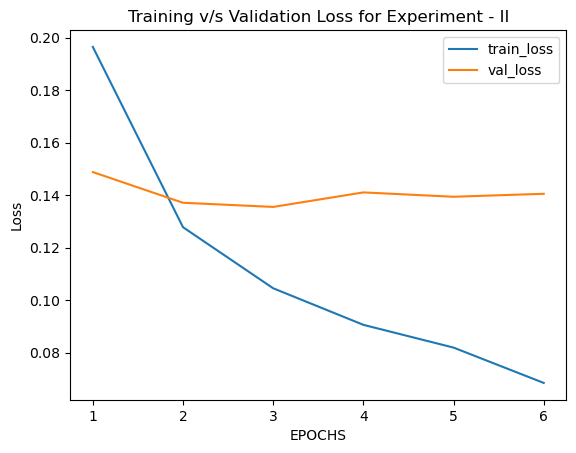

In [29]:
import matplotlib.pyplot as plt
EPOCH = np.arange(1,7)
plt.plot(EPOCH,results['train_loss'], label = 'train_loss')

plt.plot(EPOCH,results['val_loss'], label = 'val_loss')
plt.xlabel("EPOCHS")
plt.ylabel("Loss")
plt.title('Training v/s Validation Loss for Experiment - II')
plt.legend()
plt.show()

In [22]:
test_dataset = df_test.reset_index(drop = True)
test_data = Ner_Data(test_dataset)
test_data_loader = DataLoader(test_data, batch_size=4, shuffle=False)

In [23]:
def test(model, testing_loader):
    test_loss, test_with_accuracy, test_without_accuracy = 0, 0, 0
    test_steps = 0
    test_preds, test_labels = [], []
    
    for idx, batch in enumerate(testing_loader):

        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)
        preds= model(input_ids=ids, attention_mask=mask, labels=labels)

        loss = preds['loss']
        logits = preds['logits'] 

        test_loss += loss.item()
        test_steps += 1
        # compute evaluation accuracy
        flattened_targets = labels.view(-1) 
        active_logits = logits.view(-1, model.num_labels) 
        flattened_predictions = torch.argmax(active_logits, axis=1)

        # only compute accuracy at active labels
        labels_without = labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)

        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        test_labels.extend(labels)
        test_preds.extend(predictions)

        tmp_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        test_with_accuracy += tmp_accuracy

        active_without_accuracy = []
        for label in labels_without.view(-1):
            if(label == label_to_ids['O'] or label == -100):
                active_without_accuracy.append(False)
            else:
                active_without_accuracy.append(True)

        active_without_accuracy = torch.as_tensor(active_without_accuracy)
        active_without_accuracy = active_without_accuracy.to(device)
#             print(active_without_accuracy.size())
#             print(flattened_targets.size())

        labels_without = torch.masked_select(flattened_targets, active_without_accuracy)
        predictions_without = torch.masked_select(flattened_predictions, active_without_accuracy)            
        tmp_without_accuracy = accuracy_score(labels_without.cpu().numpy(), predictions_without.cpu().numpy())
        test_without_accuracy += tmp_without_accuracy
            
    labels = [ids_to_label[id.item()] for id in test_labels]
    predictions = [ids_to_label[id.item()] for id in test_preds]
    test_loss = test_loss / test_steps
    test_with_accuracy = test_with_accuracy / test_steps
    test_without_accuracy = test_without_accuracy / test_steps
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_with_accuracy}")
    print(f"Test Accuracy Without O: {test_without_accuracy}")
    return labels, predictions

In [24]:
labels, predictions = test(model, test_data_loader)

Test Loss: 0.14131849652683065
Test Accuracy: 0.9641340770597987
Test Accuracy Without O: 0.8061552460543501


In [25]:
from seqeval.metrics import classification_report
print(classification_report([labels], [predictions]))

              precision    recall  f1-score   support

         art       0.18      0.10      0.13        41
         eve       0.22      0.13      0.17        15
         geo       0.79      0.86      0.83      3788
         gpe       0.97      0.89      0.93      1636
         nat       1.00      0.14      0.25        28
         org       0.71      0.58      0.64      2003
         per       0.72      0.74      0.73      1676
         tim       0.86      0.83      0.84      2031

   micro avg       0.80      0.79      0.80     11218
   macro avg       0.68      0.54      0.56     11218
weighted avg       0.80      0.79      0.79     11218



In [26]:
def align_word_ids(texts):
  
    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=512, truncation=True)
    word_ids = tokenized_inputs.word_ids()
    
    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(1)
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(1 if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids


def evaluate_one_text(model, sentence):
    text_input = tokenizer(sentence, padding='max_length', max_length = 512, truncation=True)
    text = tokenizer(sentence, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
    mask = text['attention_mask'].to(device)
    input_id = text['input_ids'].to(device)
    label_ids = torch.Tensor(align_word_ids(sentence)).unsqueeze(0).to(device)

    logits = model(input_id, mask, None)
    logits_clean = logits[0][label_ids != -100]

    predictions = logits_clean.argmax(dim=1).tolist()
    prediction_label = [ids_to_label[i] for i in predictions]
    text_tokens = tokenizer.convert_ids_to_tokens(text_input['input_ids'])
    
    print(sentence)
    print("Tokenized Sentence:",text_tokens[1:text_tokens.index('[SEP]')])
    print("Predicted Labels:",prediction_label)
            
evaluate_one_text(model, 'Sundar Pichai is the CEO of Google .')


Sundar Pichai is the CEO of Google .
Tokenized Sentence: ['Sun', '##dar', 'Pi', '##cha', '##i', 'is', 'the', 'CEO', 'of', 'Google', '.']
Predicted Labels: ['B-per', 'I-per', 'O', 'O', 'O', 'O', 'B-org', 'O']


## SAVING THE MODEL

In [27]:
torch.save(model, './model.pth')

In [28]:
# model3 = torch.load('./model.pth')